In [2]:
import json
import matplotlib.pyplot as plt

In [3]:
hpi_yellow = '#f6a800'
hpi_orange = '#dd6108'
hpi_red = '#b1063a'
hpi_gray = '#5a6065'
hpi_blue = '#007a9e'
hpi_green = '#007f6f'
hpi_lime = '#779a0b'
hpi_purple = '#7664a0'

In [4]:
def load_file(name):
    with open(name, 'r') as f:
        data = json.loads(f.read())
    return data


[103.5, 97, 99, 105]


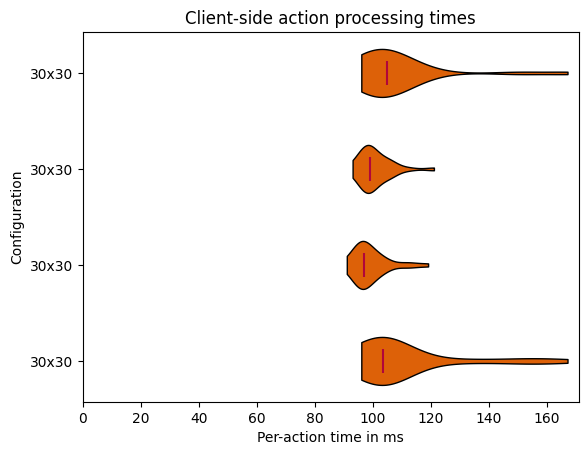

In [75]:
d = load_file('./../data/tick-patients/2023-06-08T12:20:40.482Z.json')
ds = [run['raw']['[Exercise] Tick'] for run in d]

parts = plt.violinplot(dataset=ds, vert=False, showextrema=False, showmedians=True)

print([run['stats']['[Exercise] Tick']['med'] for run in d])

plt.title("Client-side action processing times")

plt.xlim(0)
plt.xlabel('Per-action time in ms')

plt.ylabel('Configuration')
plt.yticks(
    ticks=range(1,len(d)+1),
    labels=[f'{run["settings"]["pas"]}x{run["settings"]["ticks"]}' for run in d]
)

for pc in parts['bodies']:
    pc.set_alpha(1)
    pc.set_facecolor(hpi_orange)
    pc.set_edgecolor('k')
    
parts['cmedians'].set_color(hpi_red)

plt.show()